In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

모듈 호출 및 데이터셋 구축

In [ ]:
import tensorflow as tf
# 생성기와 판별자 가져오기를 지원하는 tensorflow_examples 
from tensorflow_examples.models.pix2pix import pix2pix
from keras.preprocessing import image

import numpy as np
from glob import glob
from PIL import Image 
import os
import time
import matplotlib.pyplot as plt

from IPython.display import clear_output

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
person_datas = glob('/content/drive/MyDrive/person2citypop/person1/*.jpg')
citypop_datas = glob('/content/drive/MyDrive/person2citypop/citypop1/*.jpg')

person_train = []
citypop_train = []

for imagename in person_datas:
    image = Image.open(imagename)
    image = image.resize((256,256))
    image = np.array(image)
    person_train.append(image)

for imagename in citypop_datas:
    image = Image.open(imagename)
    image = image.resize((256,256))
    image = np.array(image)
    citypop_train.append(image)


In [ ]:
person_train = np.array(person_train)
citypop_train = np.array(citypop_train)

In [ ]:
person_train.shape

(1013, 256, 256, 3)

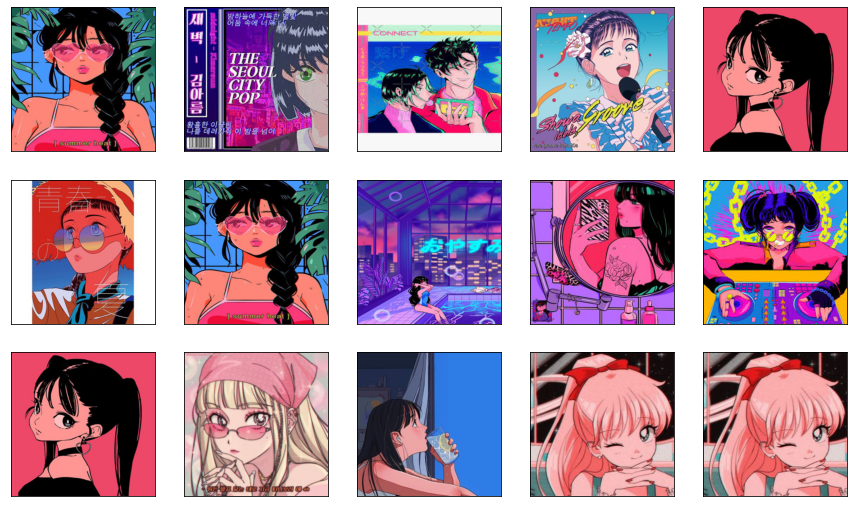

In [ ]:
#Data 확인 
plt.figure(figsize=(15,9))
for i in range(15):
    img_idx = np.random.randint(0,29)
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(citypop_train[img_idx])
    


In [ ]:
#pixel 값을 -1 ~ 1 사이로 조정 
person_train = person_train.astype(np.float32) / 127.5
citypop_train = citypop_train.astype(np.float32) /127.5

print(person_train.shape, citypop_train.shape)

(1013, 256, 256, 3) (107, 256, 256, 3)


In [ ]:
#dataset 구성
person_train = tf.data.Dataset.from_tensor_slices(person_train).shuffle(buffer_size= 30).batch(1).repeat()
citypop_train = tf.data.Dataset.from_tensor_slices(citypop_train).shuffle(buffer_size= 30).batch(1).repeat()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


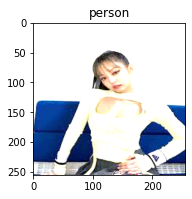

In [ ]:
#샘플 데이터 확인
sample_person = next(iter(person_train))
sample_citypop = next(iter(citypop_train))
# 인물데이터의 경우 
plt.subplot(121)
plt.title('person')
plt.imshow(sample_person[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


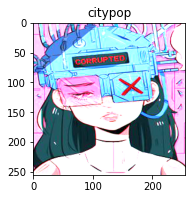

In [ ]:
#시티팝 데이터의 경우 
plt.subplot(122)
plt.title('citypop')
plt.imshow(sample_citypop[0])

Pix2Pix 모델 가져와 재사용하기 

In [ ]:
#컬러이미지니까 OUTPUT_CHANNEL은 당연히 3
#CycleGAN은 BATCH_NORM이 아니라 INSTANCE_NORM을 한다 

OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


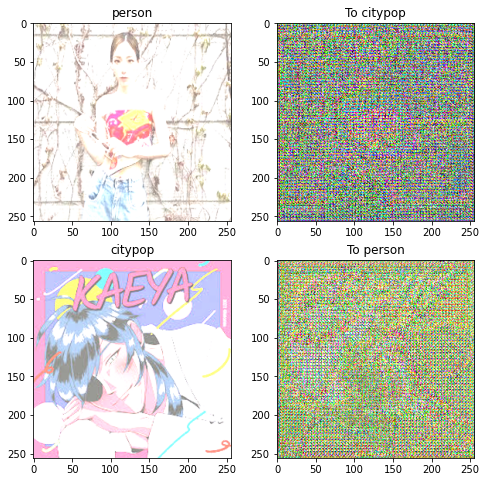

In [ ]:
to_citypop = generator_g(sample_person)
to_person = generator_f(sample_citypop)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_person, to_citypop, sample_citypop, to_person]
title = ['person', 'To citypop', 'citypop', 'To person']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

손실함수

In [ ]:
LAMBDA = 10 

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
#판별자 손실함수
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

#생성자 손실함수
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

#cycle 손실함수 
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1


#원래 이미지와 차이 
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss


In [ ]:
#옵티마이저
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
#체크포인트
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

훈련하기

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [ ]:
EPOCHS = 100

for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((person_train, citypop_train)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_person)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

KeyboardInterrupt: ignored